In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone


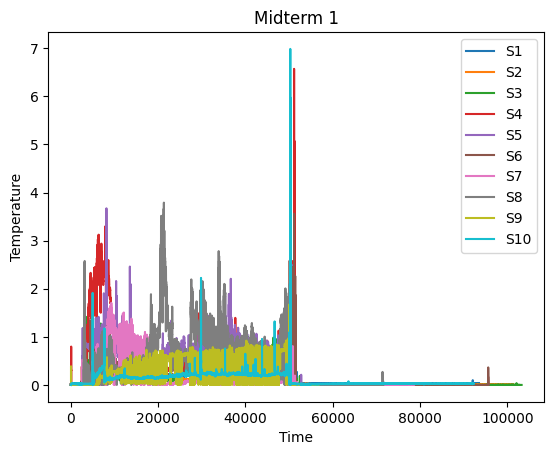

In [ ]:
def get_original_data(sid, exam, feature):
    if exam == 1:
        exam = 'Midterm 1'
    elif exam == 2:
        exam = 'Midterm 2'
    elif exam == 3:
        exam = 'Final'

    data = pd.read_csv(f'data/S{sid}/{exam}/{feature}.csv', header=None)
    data.columns = [f'{feature}']
    return data.iloc[2:]

exam = pd.DataFrame()
for i in range(1, 11):
    df = get_original_data(i, 3, 'EDA')
    df.columns= [f'S{i}']
    exam = pd.concat([exam, df], axis=1)

plt.plot(exam)
plt.legend(exam.columns)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Midterm 1')
plt.show()

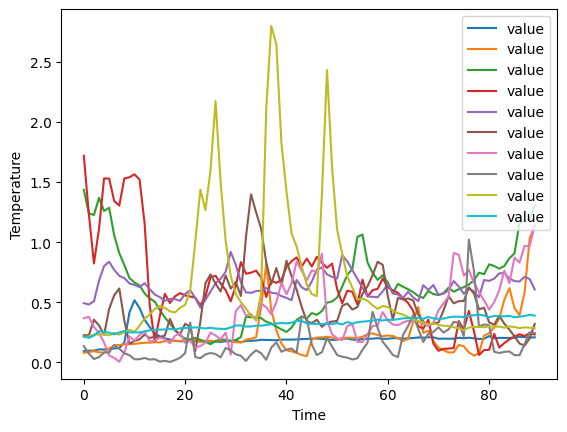

In [ ]:
def get_data(sid, exam, feature, time_adjustment=1):
    if exam == 1:
        exam = 'Midterm 1'
    elif exam == 2:
        exam = 'Midterm 2'
    elif exam == 3:
        exam = 'Final'

    data = pd.read_csv(f'data/S{sid}/{exam}/{feature}.csv', header=None)
    data.columns = [f'{feature}']
    
    session_start_unix = data.iloc[0, 0]
    sample_rate = data.iloc[1, 0]
    
    session_start_dt = datetime.fromtimestamp(session_start_unix, tz=timezone.utc)
    exam_start_dt = session_start_dt.replace(hour=session_start_dt.hour+time_adjustment, minute=0, second=0, microsecond=0)
    exam_start_time = int(exam_start_dt.timestamp())
    
    # Adjust to gather data points every 1 minute from the start of the exam
    if exam == 'Final':
        time_points = np.arange(exam_start_time, exam_start_time + 10800 + 1, 60)  # 10800 seconds = 3 hours
    else:
        time_points = np.arange(exam_start_time, exam_start_time + 5400 + 1, 60)

    data = data.iloc[2:].reset_index(drop=True)  # Remove first two rows (start time & sample rate)
    data['Timestamp'] = session_start_unix + (data.index / sample_rate)
    data['value'] = data[f'{feature}'].astype(float)  # Ensure TEMP is float for calculations
    
    # Aggregate data for every 1 minute
    data['minute'] = pd.cut(data['Timestamp'], bins=time_points, right=False, labels=[(t - exam_start_time) / 60 for t in time_points[:-1]])
    avg_temp_per_min = data.groupby('minute', observed=False)['value'].mean().dropna()

    return avg_temp_per_min

exam = pd.DataFrame()
for i in range(1, 11):
    df = get_data(i, 2, 'EDA')
    df.columns= [f'S{i}']
    exam = pd.concat([exam, df], axis=1)

plt.plot(exam)
plt.legend(exam.columns)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

In [30]:
# def get_grade(sid, exam):
#     if exam == 1:
#         exam = 'Midterm 1'
#     elif exam == 2:
#         exam = 'Midterm 2'
#     elif exam == 3:
#         exam = 'Final'

#     grades = pd.read_csv('processed_data/grades.csv')
#     grade = grades[grades['Name'] == f'S{sid}_{exam}']['Percentage_grade'].values[0]
#     return grade

def get_grades(sid):
    grades = pd.read_csv('processed_data/grades.csv')
    sgrade = []
    for i in ['Midterm 1', 'Midterm 2', 'Final']:
        grade = grades[grades['Name'] == f'S{sid}_{i}']['Percentage_Score'].values[0]
        sgrade.append(grade)
    return sgrade

get_grades(1)

[np.float64(0.78), np.float64(0.82), np.float64(0.91)]

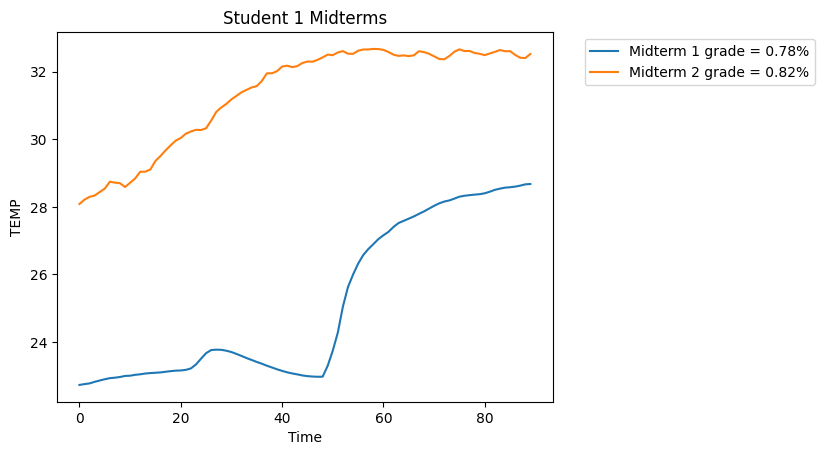

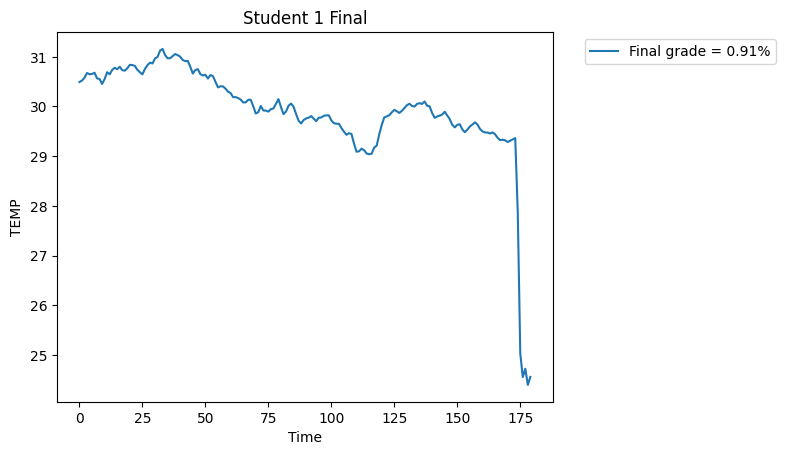

In [51]:
# compare same student different exams
def plot_single_student(sid, feature):
    exam1 = get_data(sid, 1, feature)
    exam2 = get_data(sid, 2, feature)
    final = get_data(sid, 3, feature)
    grades = get_grades(sid)

    plt.plot(exam1, label=f'Midterm 1 grade = {grades[0]}%')
    plt.plot(exam2, label=f'Midterm 2 grade = {grades[1]}%')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Time')
    plt.ylabel(f'{feature}')
    plt.title(f'Student {sid} Midterms')
    plt.show()

    plt.plot(final, label=f'Final grade = {grades[2]}%')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Time')
    plt.ylabel(f'{feature}')
    plt.title(f'Student {sid} Final')
    plt.show()

plot_single_student(1, 'TEMP')